# Soy Future Market Analysis Report

## Market Info
#### Symbol Convention
[Base Symbol]+[Month Code]+[Year]

- For example, ```ZSQ25``` is the Chicago soybean future with expiration in September 2025.
- ```ZM=F``` refers to the **nearest to expiration** Chicago soy meal futures contract. For example, from March to April, the ```ZM=F``` tracks the May futures ```ZMK```.

#### Quick Summary
- Like wheat, soybeans and sunflower seeds aren't generally used or consumed directly, but require further processing. Unlike wheat, both soy and sunflower have applications for other food-production chains; soy is a valuable protein source for livestock feed, and both soy and sunflower oil are major vegetable fats used in food, food products, and industrial applications.

| Commodity Name     | Symbol | Key Growing Regions    | Primary Uses                       | Planting Season | Harvest Season | Vulnerable to                              | Expiry Month                           |
|--------------------|--------|------------------------|------------------------------------|-----------------|----------------|--------------------------------------------|----------------------------------------|
| **Whole Soybeans** | `ZS`   | Central U.S. (Plains)  | Edamame, soy sauce, meat substitutes           | Mar-Apr         | Sep-Oct        | leaf disease, cold damage & drought        | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |
| **Soybean Oil**    | `ZL`   | N/A  | Vegetable oil, food additives, ink, paint     | N/A             | N/A        | N/A            | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |
| **Soybean Meal**   | `ZM`   | N/A | Protein isolate, tofu, soy milk                     | N/A             | N/A        | N/A | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |

#### Geopolitical & Export Demand
- The U.S. is the world's second largest producer of soy, after Brazil.
- China is the largest importer from the U.S., for ~$20Bn/year as of 2025.
- Mexico and the EU also import ~$2Bn/year of soy.
- Large stocks of, production capacities of, and agro-industrial demand for soy all mean that the soy futures market is highly liquid.

#### Last trading day
- The business day before the 15th calendar day of the contract month. Usually, it would be the 14th of that day at 1:20pm CT.
- The soy is already in the warehouse before the expiration date. Once the ownership is transferred to the long trader, the long trader must pay the storage fees.
- After the last trading day, the buyer of the contract must take delivery. This will incur daily warehouse fee, handling fees and delivery fees.
- Most trades will close their positions before the First Notice day, or the last trading day.

In [1]:
# Lots of things to import

import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns

In [20]:
# Reading data from file
ZS_data = pd.read_csv('ZS-data.csv', parse_dates=['Date'])
ZL_data = pd.read_csv('ZL-data.csv', parse_dates=['Date'])
ZM_data = pd.read_csv('ZM-data.csv', parse_dates=['Date'])

ZS_new = pd.read_csv('ZS-new.csv', parse_dates=['Date'])
ZL_new = pd.read_csv('ZL-new.csv', parse_dates=['Date'])
ZM_new = pd.read_csv('ZM-new.csv', parse_dates=['Date'])

dfs = [ZS_data, ZL_data, ZM_data, ZS_new, ZL_new, ZM_new]

# Parse dates and break down into Day/Month/Year/Day of Year
for d in dfs:
    d['Date'] = pd.to_datetime(d['Date'], utc=True)
    d.set_index('Date', inplace=True)
    d['Year'] = d.index.year
    d['Month'] = d.index.month
    d['Day'] = d.index.day
    d['Day_Of_Year'] = d.index.dayofyear

# ZS_data['Date'] = pd.to_datetime(ZS_data['Date'], utc=True)
# ZL_data['Date'] = pd.to_datetime(ZL_data['Date'], utc=True)
# ZM_data['Date'] = pd.to_datetime(ZM_data['Date'], utc=True)

# ZS_data.set_index('Date', inplace=True)
# ZL_data.set_index('Date', inplace=True)
# ZM_data.set_index('Date', inplace=True)

# ZS_data['Year'] = ZS_data.index.year
# ZS_data['Month'] = ZS_data.index.month
# ZS_data['Day'] = ZS_data.index.day
# ZS_data['Day_Of_Year'] = ZS_data.index.dayofyear
# ZL_data['Year'] = ZL_data.index.year
# ZL_data['Month'] = ZL_data.index.month
# ZL_data['Day'] = ZL_data.index.day
# ZL_data['Day_Of_Year'] = ZL_data.index.dayofyear
# ZM_data['Year'] = ZM_data.index.year
# ZM_data['Month'] = ZM_data.index.month
# ZM_data['Day'] = ZM_data.index.day
# ZM_data['Day_Of_Year'] = ZM_data.index.dayofyear

# Log returns
ZS_data['Log Return'] = np.log(ZS_data['Close']) - np.log(ZS_data['Close'].shift(1))
ZS_new['Log Return'] = np.log(ZS_new['Close']) - np.log(ZS_new['Close'].shift(1))

# Rename to separate after concatenation
ZS_dict = {}
ZL_dict = {}
ZM_dict = {}

for col in ZS_data.columns:
    # ZS_dict[col] = 'ZS ' + col
    ZL_dict[col] = 'ZL ' + col
    ZM_dict[col] = 'ZM ' + col

ZS_data.rename(columns=ZS_dict, inplace=True)
ZL_data.rename(columns=ZL_dict, inplace=True)
ZM_data.rename(columns=ZM_dict, inplace=True)
ZL_new.rename(columns=ZL_dict, inplace=True)
ZM_new.rename(columns=ZM_dict, inplace=True)


# The below split might still be bad but should be usable...

# Unnecessary - we already import data as split by 2025-01-01
# splitting_point = '2025-01-01'
# feature_cols = ['Close', 'Log Return']

ZS_train = ZS_data
ZS_test = ZS_new
# train_indices = ZS_train.index
# test_indices = ZS_test.index

ZL_train = ZL_data #.loc[ZL_data.index.isin(train_indices)]
ZL_test = ZL_new #.loc[ZL_data.index.isin(test_indices)]
ZM_train = ZM_data #.loc[ZM_data.index.isin(train_indices)]
ZM_test = ZM_new #.loc[ZM_data.index.isin(test_indices)]

ZZ_data = pd.concat([ZL_data, ZM_data], axis=1)
ZZ_train = ZZ_data #.loc[ZZ_data.index.isin(train_indices)]
ZZ_test =  pd.concat([ZL_new, ZM_new], axis=1) #ZZ_data.loc[ZZ_data.index.isin(test_indices)]

ZW_data = pd.concat([ZL_data, ZM_data, ZS_data], axis=1)
ZW_train = ZW_data #.loc[ZW_data.index.isin(train_indices)]
ZW_test = pd.concat([ZL_new, ZM_new, ZS_new], axis=1) #ZW_data.loc[ZW_data.index.isin(test_indices)]

## Initial Fits
Our EDA and desiderata mean we should likely be trying to predict daily log-returns of closing prices, so we add a feature of that form to ZS. They also point us towards a few possibilities for a predictive fit, with a few major possibilities:
* Some kind of time-series linear fit, like an AR with lags 1 and 10 provided by the EDA
* An XGBoost model, to see if a gold-standard nonparametric model can do well
* An OLS linear fit on *untransformed pricing data* for some horizon (like 30 days) to predict the *log return*
  

[0.01967063 0.05949722] 5.2237287136505736e-05


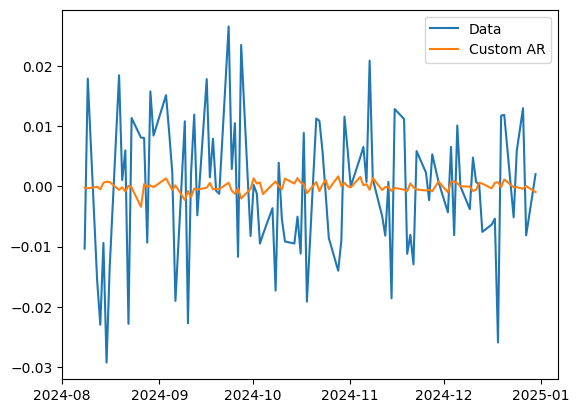

Cross-validation R2 scores: [-0.0132196  -0.05401267 -0.02643087 -0.02025646 -0.07294257 -0.0771574
 -0.1988062  -0.00166884 -0.02533417 -0.04607446]
Average R2: -0.0536
[0]	validation_0-rmse:0.01341	validation_0-r2_score:0.00034	validation_1-rmse:0.01153	validation_1-r2_score:-0.00141
[50]	validation_0-rmse:0.01332	validation_0-r2_score:0.01312	validation_1-rmse:0.01154	validation_1-r2_score:-0.00291
[100]	validation_0-rmse:0.01326	validation_0-r2_score:0.02276	validation_1-rmse:0.01155	validation_1-r2_score:-0.00432
[150]	validation_0-rmse:0.01321	validation_0-r2_score:0.03048	validation_1-rmse:0.01155	validation_1-r2_score:-0.00527
[200]	validation_0-rmse:0.01315	validation_0-r2_score:0.03884	validation_1-rmse:0.01155	validation_1-r2_score:-0.00483
[250]	validation_0-rmse:0.01310	validation_0-r2_score:0.04583	validation_1-rmse:0.01156	validation_1-r2_score:-0.00538
[300]	validation_0-rmse:0.01306	validation_0-r2_score:0.05159	validation_1-rmse:0.01159	validation_1-r2_score:-0.01061


<Axes: title={'center': 'The XGBoost Model on the training set'}, xlabel='Date', ylabel='Log Return'>

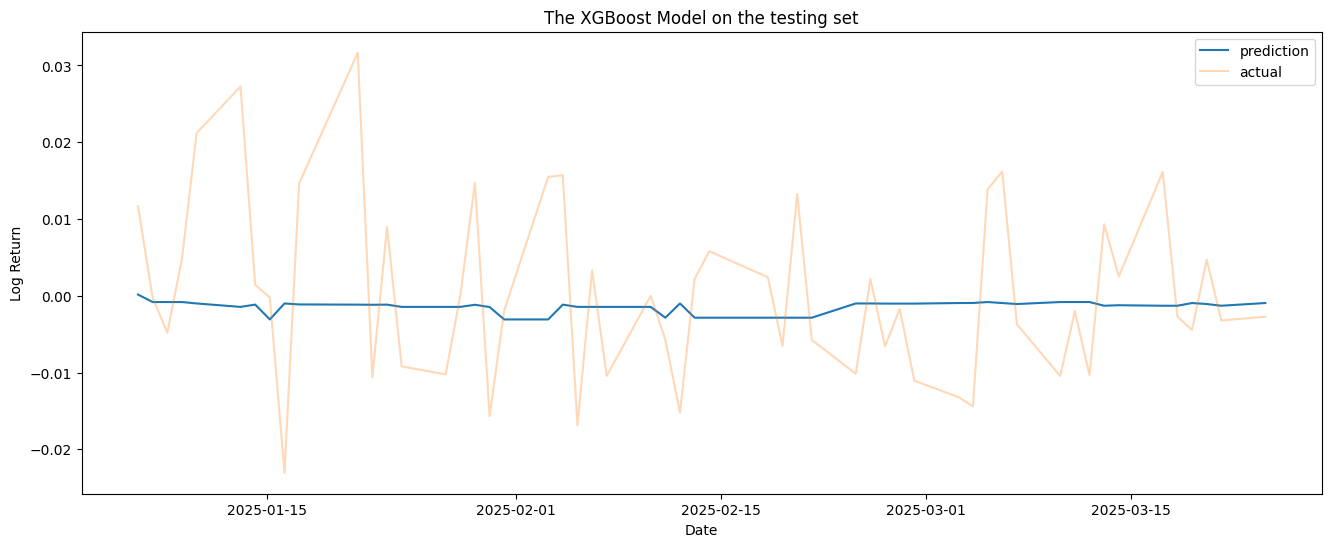

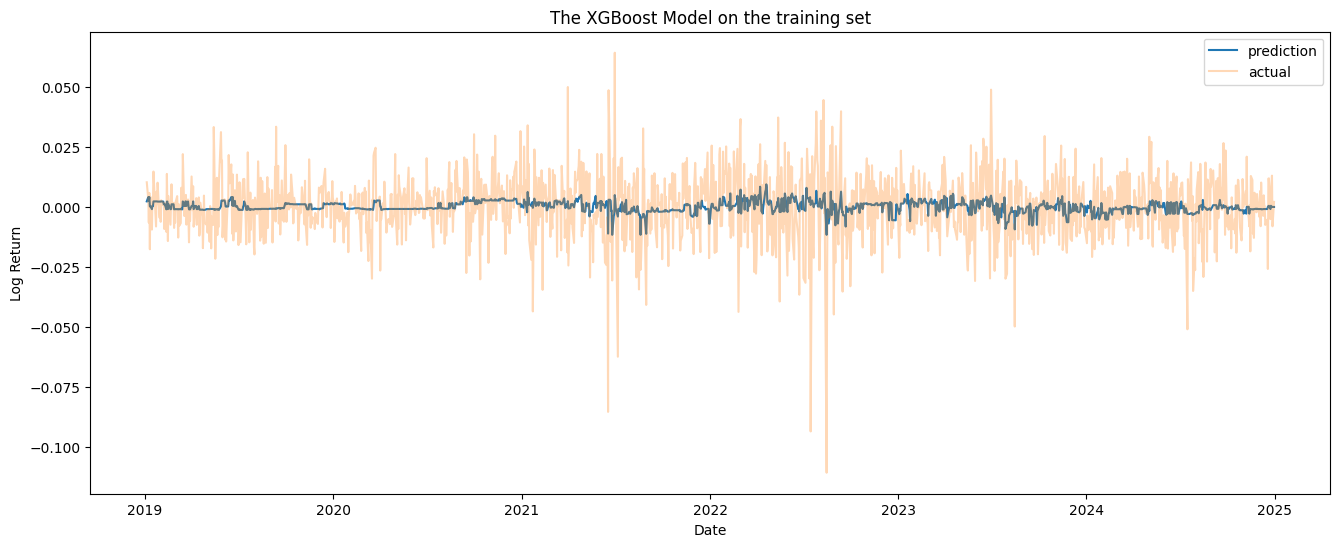

In [22]:
# Linear Lag model
def X_y_for_lags(ts, num_lags):
    '''
    Inputs
        ts: A numpy array of size (n,) representing a time series
        num_lags: The number of lags to include in the resulting design matrix

    Outputs
        X: A numpy array of size (n - num_lags, num_lags). 
            The first column is lag 1, second column is lag 2, etc 
        y: The time series starting at entry num_lags
    '''
    ts = ts.astype(float)
    n = len(ts)
    X = np.zeros(shape=(n - num_lags, num_lags))
    for i in range(num_lags):
        X[:, i] = ts[num_lags - i - 1 : n - i - 1]
    y = ts[num_lags:]
    return X, y

# holdout
ZW_tt = ZW_train[1:-20]

# Fit from (P)ACF - linear time-series in terms of x_1 and x_10
design_matrix, targets = X_y_for_lags(ZW_tt['Log Return'], 10)
soymodel = LinearRegression()
soymodel_preds = []

for i in range(-100, 0):
    X_tt, y_tt = design_matrix[:i], targets[:i]
    X_ho, y_ho = design_matrix[[i]], targets.iloc[i]

    X_tt = X_tt[:,[0, 9]]
    X_ho = X_ho[:,[0, 9]]

    soymodel.fit(X_tt, y_tt)
    soymodel_preds.append(soymodel.predict(X_ho)[0])

print(soymodel.coef_, soymodel.intercept_)
plt.plot(ZW_train['Log Return'].index[-100:], ZW_train['Log Return'].iloc[-100:], label = 'Data')
plt.plot(ZW_train['Log Return'].index[-100:], soymodel_preds, label = 'Custom AR')
plt.legend()
plt.show()  # It's... not actually all that good, sadly.

# XG Boost model w/o regularization - how good of a score does it get on the training data?
# TO COMPLETE
tscv = TimeSeriesSplit(n_splits=10)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    eval_metric=r2_score,
#    device='cuda',
    reg_alpha=0.1,
    reg_lambda=0.1,
#    gamma=0.1,
#    early_stopping_rounds=250,
#    min_child_weight=5,
#    subsample=0.7,
#    colsample_bytree=0.7,
)

# ZW_train.info()
# ZW_train.head
ZW_train = ZW_train.iloc[1:]
ZW_test = ZW_test.iloc[1:]

cv_scores = cross_val_score(xgb_model, ZW_train[['ZL Close', 'ZM Close', 'Close']], ZW_train['Log Return'], cv=tscv, scoring='r2')
print(f'Cross-validation R2 scores: {cv_scores}')  # Convert to positive MAE values
print(f'Average R2: {np.mean(cv_scores):.4f}')

xgb_model.fit(ZW_train[['ZL Close', 'ZM Close', 'Close']], ZW_train['Log Return'], verbose=50,eval_set=[(ZW_train[['ZL Close', 'ZM Close', 'Close']], ZW_train['Log Return']), (ZW_test[['ZL Close', 'ZM Close', 'Close']], ZW_test['Log Return'])])
y_pred = xgb_model.predict(ZW_test[['ZL Close', 'ZM Close', 'Close']])

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the training set')
sns.lineplot(x=ZW_train['Log Return'].index, y=xgb_model.predict(ZW_train[['ZL Close', 'ZM Close', 'Close']]), label='prediction')
sns.lineplot(x=ZW_train['Log Return'].index, y=ZW_train['Log Return'], label='actual', alpha = 0.3)

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the testing set')
sns.lineplot(x=ZW_test['Log Return'].index, y=y_pred, label='prediction')
sns.lineplot(x=ZW_test['Log Return'].index, y=ZW_test['Log Return'], label='actual', alpha = 0.3)

# Cross-Validation (To-Do)

In [ ]:
# Make a KFold object
# remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 4
kfold = KFold(num_splits, shuffle=True, random_state=518)

# This array will hold the mse for each model and split

s = np.zeros((num_models, num_splits))

# set a split counter
i = 0

# loop through the kfold here
for train_index, test_index in kfold.split(ZS_train):
    # cv training set
    ZS_tt = ZS_train.iloc[train_index]
    
    # cv holdout set
    ZS_ho = ZS_train.iloc[test_index]
    
    # "Fit" mean and get holdout root mean squared error for the baseline model.
    # No need to use an sklearn function:  just get the mean.  
    # baseline_pred should be a numpy array with the same number of elements as ZS_ho

    baseline_pred = ZS_tt.median_house_value.mean()*np.ones(len(ZS_ho))
    rmses[0, i] = root_mean_squared_error(ZS_ho.median_house_value, baseline_pred)
    
    # Fit and get ho rmse for slr model
    slr = LinearRegression()
    slr.fit(ZS_tt[['median_income']], ZS_tt.median_house_value)
    rmses[1, i] = root_mean_squared_error(ZS_ho.median_house_value, slr.predict(ZS_ho[['median_income']]))
    
    ## Fit and get ho mse for mlr model
    mlr = LinearRegression()
    mlr.fit(ZS_tt[['median_income', 'households']], ZS_tt.median_house_value)
    rmses[2, i] = root_mean_squared_error(ZS_ho.median_house_value, mlr.predict(ZS_ho[['median_income', 'households']])) 
    
    ## Fit and get ho rmse for the spatial model
    knn = KNeighborsRegressor()
    knn.fit(ZS_tt[['latitude', 'longitude']], ZS_tt.median_house_value)
    rmses[3, i] = root_mean_squared_error(ZS_ho.median_house_value, knn.predict(ZS_ho[['latitude', 'longitude']]))
    
    i = i + 1